# Traveling salesman problem

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# для гифки
import os
import glob
import imageio
images = 'images/'

Создадим изначальную карту.

In [2]:
letters = [f'{chr(i)}' for i in range(65, 65 + 26)] + [f'{chr(i)}*' for i in range(65, 65 + 26)]  

In [3]:
class City:
    def __init__(self, coord, number):
        self.x = coord[0]
        self.y = coord[1]
        self.name = letters[number]
        
    def distance(self, city):
        return np.sqrt((self.x - city.x) ** 2 + (self.y - city.y) ** 2)
    
    def __repr__(self):
        return f'{self.name}: ({str(self.x)}; {self.y})'

In [4]:
def map_city(cities_num, cities_range):
    return [City(np.random.randint(1, cities_range, size=2), j) for j in range(cities_num)]

In [5]:
np.random.seed(13)
not_closed_road = map_city(len(letters), 2000)

In [6]:
closed_road = not_closed_road + [not_closed_road[0]]

In [7]:
def total_distance(path, cities_lst): # тождественно нашей целевой функции
    dist_lst = []
    for j in range(len(path) - 1):
        dist_lst.append(cities_lst[j].distance(cities_lst[j + 1]))
    dist_lst.append(cities_lst[j + 1].distance(cities_lst[0]))
    return sum(dist_lst)

In [8]:
path = [city.name for city in closed_road]

In [9]:
route_dist = total_distance(path=path, cities_lst=closed_road)

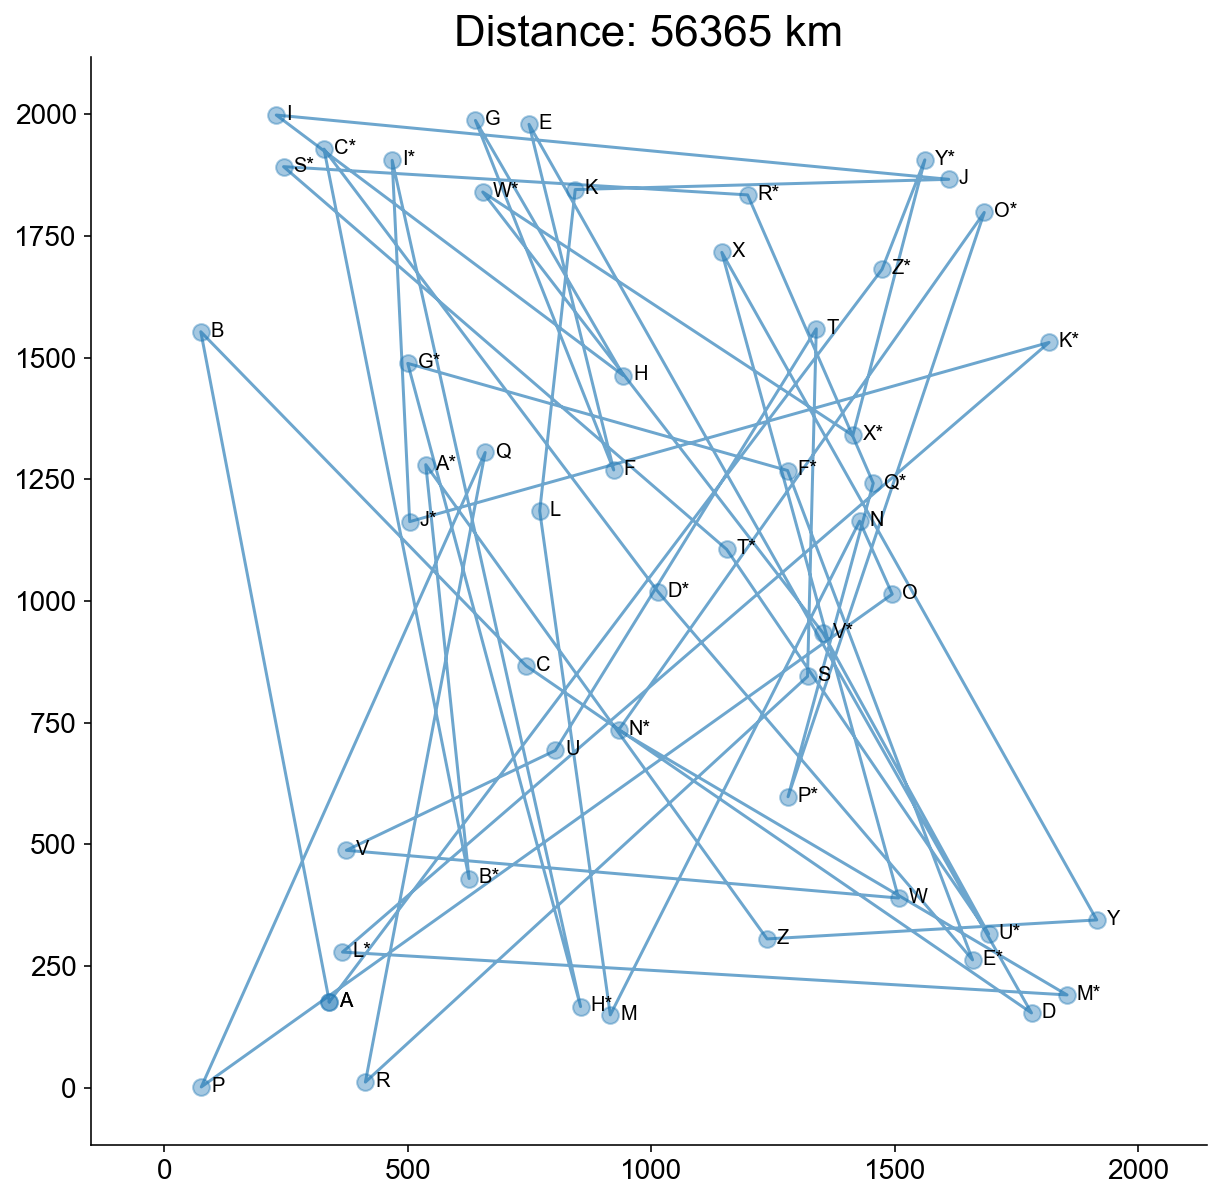

In [10]:
fig = plt.figure(figsize=(10,10))

# Удаляем лишние границы
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.title(f'Distance: {int(round(route_dist))} km', fontsize=22)
plt.plot([city.x for city in closed_road],
         [city.y for city in closed_road], alpha=0.65)
plt.scatter([city.x for city in closed_road], 
            [city.y for city in closed_road], s=70, marker='o', alpha=0.4)

for j in range(len(closed_road)):
    plt.text(closed_road[j].x + 20, closed_road[j].y - 10,  closed_road[j].name)
    
plt.axis("equal")
sns.set_style("white")

In [24]:
fig.savefig("TSP1.png", bbox_inches='tight', dpi=300)

Заготовка для гифки (сделано Филиппом):

In [11]:
def create_animated_gif(files, animated_gif_name, pause=0):
    if pause != 0:
        # Load the gifs up several times in the array, to slow down the animation
        frames = []
        for file in files:
            count = 0
            while count < pause:
                frames.append(file)
                count+=1
        print("Total number of frames in the animation:", len(frames))
        files = frames
    images = [imageio.imread(file) for file in files]
    imageio.mimsave(animated_gif_name, images, duration = 0.25)

In [12]:
# удаляет из папки все картинки
for f in glob.glob("images/*.png"):
    os.remove(f)

In [13]:
def make_plot(indiv, i):
    ans = indiv.map + [indiv.map[0]]
    
    fig = plt.figure(figsize=(10,10))

    # Удаляем лишние границы
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 

    # Корректируем оси абсцисс и ординат
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 

    plt.title(f'Distance: {int(round(indiv.dist))} km', fontsize=22)
    plt.plot([city.x for city in ans],
             [city.y for city in ans], alpha=0.65)
    plt.scatter([city.x for city in ans], 
                [city.y for city in ans], s=70, marker='o', alpha=0.4)

    for j in range(len(indiv.map)):
        plt.text(indiv.map[j].x + 20, indiv.map[j].y - 10, indiv.map[j].name)

    plt.axis("equal")
    
    fig.savefig('images/{}.png'.format(i+1), bbox_inches='tight', dpi=300)

Реализуем генетический алгоритм.

In [14]:
class Individual:
    def __init__(self, cities_lst, id_of_individual):
        self.map = random.sample(cities_lst[:-1], len(cities_lst[:-1]))
        self.path = [city.name for city in self.map]
        self.id_of_individual = id_of_individual
        self.dist = None
        self.fitness = None
        
    def __repr__(self):
        return f'Individual {self.id_of_individual}: Distance = {int(round(self.dist))} km'

In [15]:
class GeneticAlgorithm:
    def __init__(self, ell, k, mutation_rate, inital_map, max_iter, 
                 make_gif=False, random_state=13):
        """
        PARAMETERS:
        ell - количество особей в поколении
        k - количество особей для размножения
        mutation_rate - коэффициент мутации
        max_iter - максимальное количество эволюций поколения (новых поколений)
        """
        self.ell = ell
        self.k = k
        self.mutation_rate = mutation_rate
        self.inital_map = inital_map
        self.max_iter = max_iter
        self.make_gif = make_gif
        self.random_state = random_state
        
        self.best_individuals = None # k наиболее приспособленных особей
        self.fittest_indivdual = None # самая приспособленная особь
        self.population = None
        self.best_target_value_history = []
        
    def search_best_path(self):        
        # создаем первое поколение
        self.population = self.create_population()
        
        # проходим этапы эволюции
        for i in tqdm(range(self.max_iter)):
            np.random.seed(self.random_state)
            
            # оцениваем приспособленность наших особей
            self.evaluate_population()
            # отбираем k наиболее наиболее приспособленных особей
            self.selection()
            self.best_target_value_history.append(self.fittest_indivdual.dist)
            
            # формируем новые поколения
            # скрещиваем особи
            for idx in range(self.k, self.ell):
                # случайно выбираем одну из наилучших особей
                select_fitted_individual = np.random.choice(self.best_individuals)
                # создаем потомка и заменяем им старую особь
                offspring = self.crossover(select_fitted_individual,
                                           self.population[idx])
                self.population[idx].map = offspring
            
            # мутируем все особи, кроме самой приспособленной
            for individual in self.population[1:]:
                self.mutate(individual)
            
            if self.make_gif:
                make_plot(self.fittest_indivdual, i)
            
        return self.fittest_indivdual

    def create_population(self):
        return [Individual(self.inital_map, i + 1) for i in range(self.ell)]
    
    def evaluate_population(self):
        F = []
        
        for individual in self.population:
            individual.dist = total_distance(individual.path + [individual.path[0]],
                                             individual.map + [individual.map[0]])
            F.append(individual.dist)
        
        for individual in self.population:
            individual.fitness = self.normalize(individual.dist,
                                                min(F), max(F))
            
    def normalize(self, z, F_best, F_worst):
        """
        INPUT:
        z - масштабируемое значение
        F_best - лучшее значение целевой функции
        F_worst - худшее значение целевой функции
        """
        return (z - F_worst) / (F_best - F_worst)
    
    def selection(self):
        """
        Оператор отбора
        """
        self.population = sorted(self.population,
                                 key=lambda individual: individual.fitness, reverse=True)
        self.best_individuals = self.population[:self.k]
        self.fittest_indivdual = self.population[0]
    
    def crossover(self, parent_fitted, parent_random):
        """
        Оператор скрещивания
        
        INPUT:
        parent_fitted - одна из самых приспособленных особей
        parent_random - случайная особь
        """
        genes_1 = int(np.random.uniform(0, 1) * len(parent_fitted.path))
        genes_2 = int(np.random.uniform(0, 1) * len(parent_fitted.path))
        
        start = min(genes_1, genes_2)
        end = max(genes_1, genes_2)
        
        if (end - start > self.ell / 2) and (np.random.uniform(0, 1) < parent_fitted.fitness):
            offspring_1 = parent_fitted.map[start:end]
            offspring_2 = [city for city in parent_random.map if city not in offspring_1]
        else:
            offspring_1 = parent_random.map[start:end]
            offspring_2 = [city for city in parent_fitted.map if city not in offspring_1]
    
        return offspring_1 + offspring_2
    
    def mutate(self, individual):
        """
        Оператор мутации
    
        INPUT:
        individual - особь, подвергающаяся мутации
        """
        for j in range(len(individual.path)):
            if np.random.uniform(0, 1) < self.mutation_rate:
                num = np.random.randint(len(individual.path))
                individual.map[j], individual.map[num] = individual.map[num], individual.map[j]        

Инициализируем.

In [16]:
a = GeneticAlgorithm(ell=1500, k=150, mutation_rate=0.001, inital_map=closed_road, 
                     max_iter=1200, random_state=232, make_gif=False)

In [17]:
a.search_best_path()

100%|██████████| 1200/1200 [17:33<00:00,  1.14it/s]


Individual 773: Distance = 12243 km

Решение TSP:

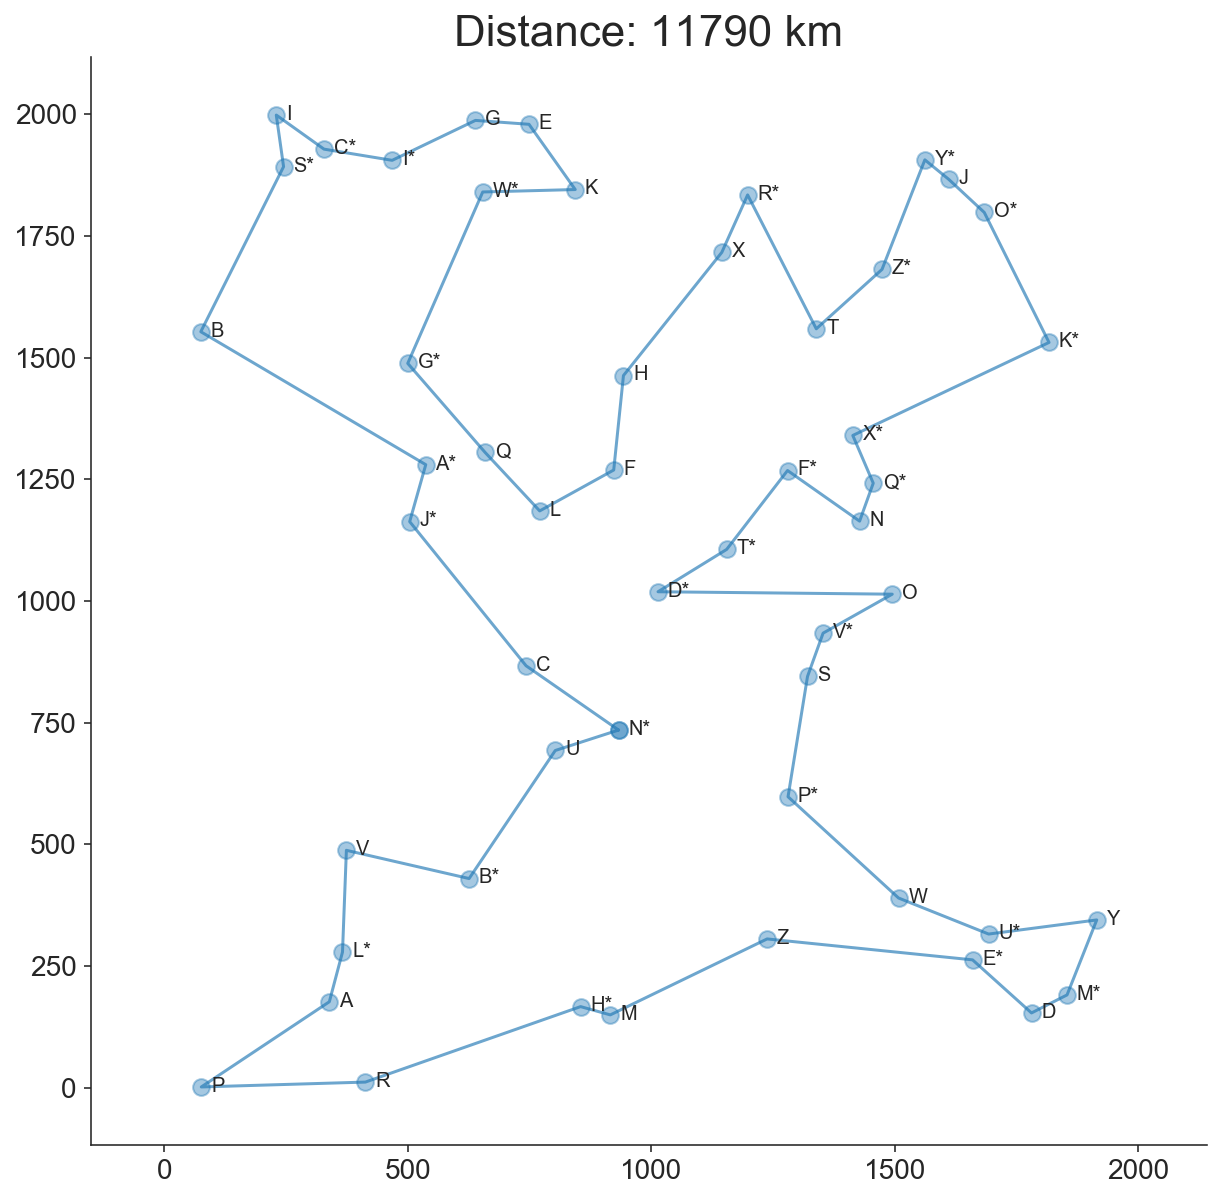

In [24]:
ans = a.fittest_indivdual.map + [a.fittest_indivdual.map[0]]

fig = plt.figure(figsize=(10,10))

# Удаляем лишние границы
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.title(f'Distance: {int(round(a.fittest_indivdual.dist))} km', fontsize=22)
plt.plot([city.x for city in ans],
         [city.y for city in ans], alpha=0.65)
plt.scatter([city.x for city in ans], 
            [city.y for city in ans], s=70, marker='o', alpha=0.4)

for j in range(len(a.fittest_indivdual.map)):
    plt.text(a.fittest_indivdual.map[j].x + 20, a.fittest_indivdual.map[j].y - 10, a.fittest_indivdual.map[j].name)

plt.axis("equal")
sns.set_style("white")

In [25]:
fig.savefig("TSP2.png", bbox_inches='tight', dpi=300)

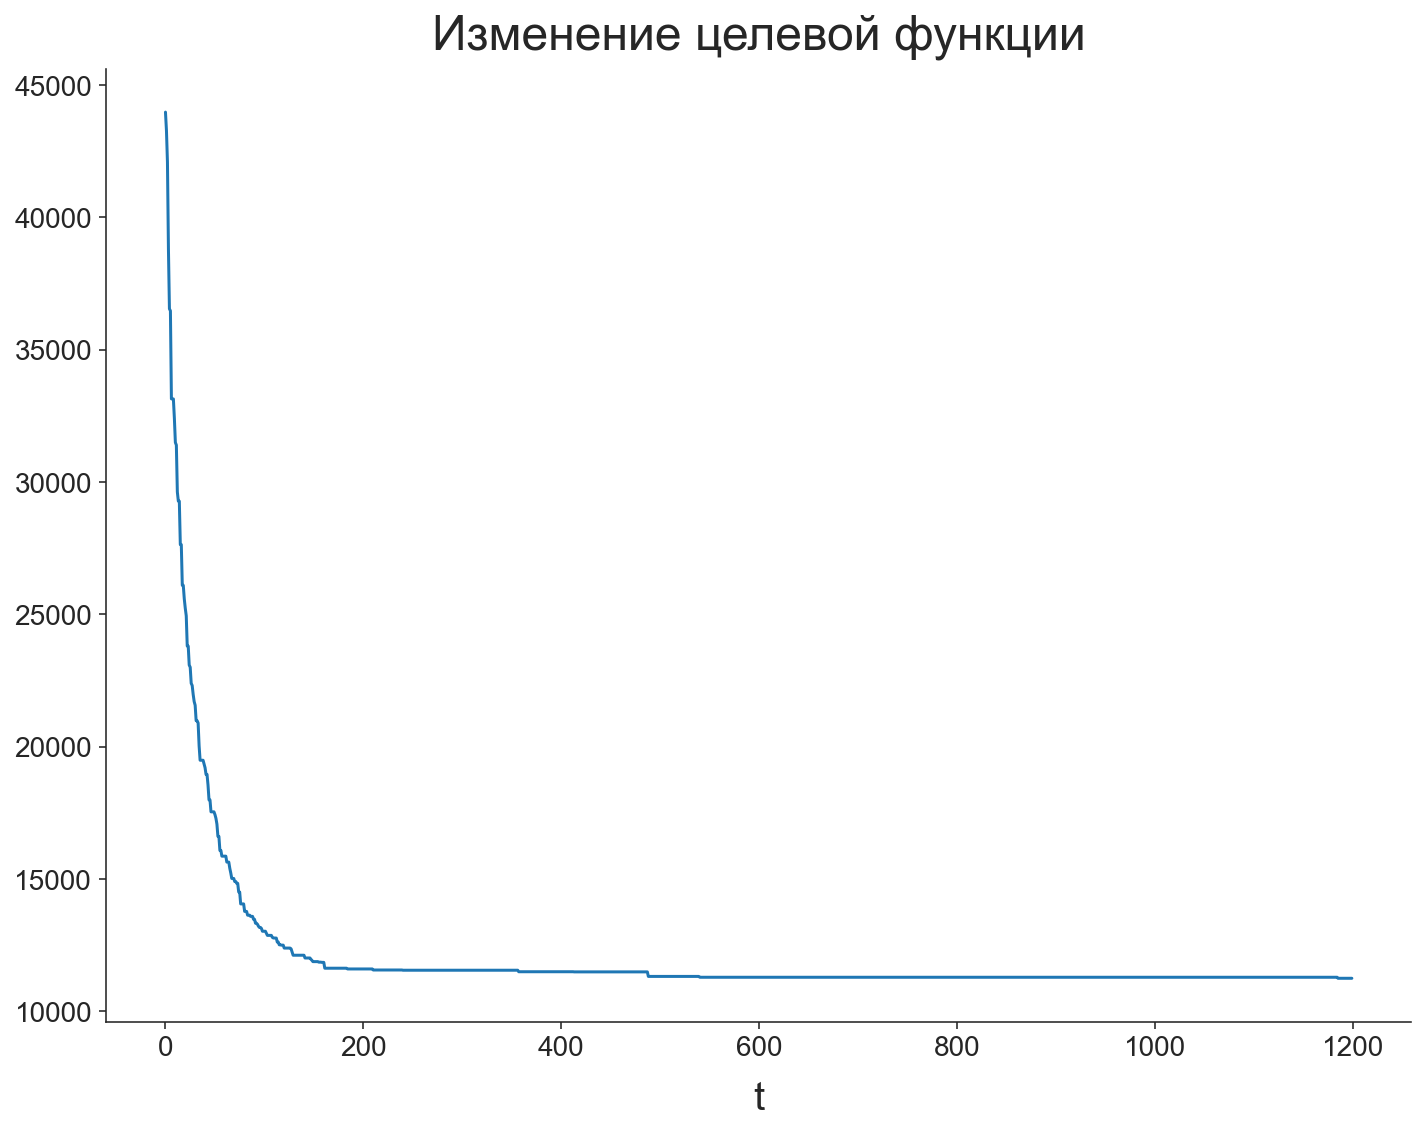

In [19]:
fig = plt.figure(figsize=(10, 8))

# Удаляем лишние границы
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.xlabel("t", fontsize=20, labelpad=10)  
plt.title("Изменение целевой функции", fontsize=24, pad=10) 
plt.plot(a.best_target_value_history)

fig.tight_layout()

In [20]:
fig.savefig("TSP3.png", bbox_inches='tight', dpi=600)

# Гифка

In [37]:
pause = 1
animated_gif_name = 'animation_TSP.gif'

In [38]:
image_path = 'images/*.png'
files = glob.glob(image_path)
files = sorted(files, key = lambda w: int(w.split('/')[-1].split('.')[0]))
create_animated_gif(files, animated_gif_name, pause)

Total number of frames in the animation: 200
